In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import random
import time
import json
import numpy as np
import pandas as pd
import xarray as xr
import xskillscore as xs

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scipy.stats import norm
from xskillscore import crps_quadrature, crps_ensemble

import sys
sys.path.append('/'.join(sys.path[0].split('/')[:-1]))
from modules.architectures import *

from modules.swag import data, models, utils, losses
from modules.swag.posteriors import SWAG

import modules.architectures as modelArchitectures
from modules.full_pipeline import compute_errors, _inner
from modules.plotting import plot_intervalmap, plot_signal
from modules.data import hp_to_equiangular
from modules.test import compute_rmse_healpix, compute_R2

In [3]:
description_epoch = 'all_const_len2_delta_6_architecture_loss_v0_2steps_constant_increasing_static_l3_long_connections_per_epoch'
figures_path = '../data/healpix/figures/' + description_epoch + '/'

config_file = 'config_s01_two_steps_small.json'

with open("../configs/" + config_file) as json_data_file:
        cfg = json.load(json_data_file)

# Define paths
datadir = cfg['directories']['datadir']
input_dir = datadir + cfg['directories']['input_dir']
model_save_path = datadir + cfg['directories']['model_save_path']
pred_save_path = datadir + cfg['directories']['pred_save_path']
metrics_path = datadir + cfg['directories']['metrics_path']

resolution = cfg['model_parameters']['resolution']
max_lead_time = cfg['training_constants']['max_lead_time']

lead_time = 6
lead_times = np.arange(lead_time, max_lead_time+lead_time, lead_time)

# Model training comparison

In [9]:
suffix = "all_const_len2_delta_6_architecture_loss_v0_2steps_constant_increasing_static_l3_long_connections_per_epoch_s02_swag_freq10_epoch11_results.pkl"

with open(model_save_path + suffix, "rb") as f:
    training_results = pickle.load(f)

In [8]:
training_results['val_loss_ev']

[[0.03589220312462782],
 [0.034251599311617066],
 [0.027782149615725976],
 [0.02785253271911413],
 [0.029190808689024104],
 [0.024031916338657453],
 [0.02255678324810683],
 [0.022773448392871643],
 [0.022375869893586912],
 [0.021746681132587653],
 [0.023701531217712606],
 [0.02158370179565951]]

In [12]:
training_results['train_loss_steps_ev']

[{'t0': [13.228347778320312,
   2.0628321170806885,
   0.9228834509849548,
   0.9612065553665161,
   1.0924382209777832,
   0.8793238401412964,
   0.7305237054824829,
   0.5730189681053162,
   0.5827925205230713,
   0.5992429256439209,
   0.6645363569259644,
   0.5991374254226685,
   0.4902127683162689,
   0.4150419533252716,
   0.4116835594177246,
   0.46861717104911804,
   0.44319671392440796,
   0.44352051615715027,
   0.44744813442230225,
   0.37125566601753235,
   0.372514933347702,
   0.3616361916065216,
   0.3537675142288208,
   0.38324469327926636,
   0.385640025138855,
   0.40831196308135986,
   0.4657122790813446,
   0.28468817472457886,
   0.27939432859420776,
   0.35433897376060486,
   0.2995421588420868,
   0.25712552666664124,
   0.2347336709499359,
   0.23629650473594666,
   0.2653256356716156,
   0.23221638798713684,
   0.2024589478969574,
   0.21906109154224396,
   0.20708441734313965,
   0.19780948758125305,
   0.19693124294281006,
   0.21572287380695343,
   0.2037758

# R2 Skill

In [ ]:
#description_epoch + f'_s02_swag_freq10_epoch_{ep}_swag_scale01_median',

In [7]:
def inner_product(x, y, dim):
    return xr.apply_ufunc(_inner, x, y, input_core_dims=[[dim], [dim]], dask='parallelized')

def compute_corr_map(pred, obs):
    print('loading data')
    t1 = time.time()
    pred.load()
    
    t2 = time.time()
    print('time to load data: ', t2 - t1)
    dims = ('time')

    obs_mean = obs.mean(dims)
    t3 = time.time()
    print('time mean obs ', t3 - t2)
    pred_mean = pred.mean(dims)
    t4 = time.time()
    print('time mean pred ', t4 - t3)

    obs_std = obs.std(dims)
    t5 = time.time()
    print('time std obs ', t5 - t4)
    pred_std = pred.std(dims)
    t6 = time.time()
    print('time std pred ', t6 - t5)

    cov = inner_product(pred - pred_mean, obs - obs_mean, dim=dims) / pred.count(dims)
    t7 = time.time()
    print('time cov ', t7 - t6)
    
    corr_map = (cov / (pred_std * obs_std)) ** 2
    t8 = time.time()
    print('time corre_map ', t8 - t7)
    
    del obs_mean, pred_mean, obs_std, pred_std, cov
    
    return corr_map

In [4]:
config_file = 'config_s01_two_steps_small.json'
ep = 11
lead_time = 6

# load config
with open("../configs/" + config_file) as json_data_file:
    cfg = json.load(json_data_file)

# define paths
datadir = cfg['directories']['datadir']
input_dir = datadir + cfg['directories']['input_dir']
model_save_path = datadir + cfg['directories']['model_save_path']
pred_save_path = datadir + cfg['directories']['pred_save_path']
metrics_path = datadir + cfg['directories']['metrics_path']

# model parameters
max_lead_time = cfg['training_constants']['max_lead_time']
len_sqce = cfg['model_parameters']['len_sqce']
delta_t = cfg['model_parameters']['delta_t']
architecture_name = cfg['model_parameters']['architecture_name']

obs = xr.open_mfdataset(pred_save_path + 'observations_nearest.nc', combine='by_coords')

description_epoch = "all_const_len{}_delta_{}_architecture_".format(len_sqce, delta_t) + architecture_name
descriptions = [
    description_epoch + f'_s02_epoch{ep}',
    description_epoch + f'_s02_ensemble_epoch_{ep}_median',
    description_epoch + f'_s02_swag_freq10_epoch{ep}_swag_scale00',
    description_epoch + f'_s02_swag_freq10_epoch_{ep}_swag_scale03_median',
    description_epoch + f'_s02_multiswag_ensemble_epoch_{ep}_swag_scale00_median'
]

labels = [
    'Classical Training',
    'Deep Ensemble Median',
    'SWA',
    'SWAG Scale 0.3 Median',
    'MultiSWA Median'
]

predictions = []

for i, description in enumerate(descriptions):
    pred = xr.open_dataset(pred_save_path + description + '.nc').chunk('auto')
    
    if i == 0:
        common_time = list(set(pred.time.values).intersection(obs.time.values))
        common_time.sort()
        common_lead_time = list(set(pred.lead_time.values).intersection(obs.lead_time.values))
        common_lead_time.sort()
        obs = obs.sel(dict(time=common_time, lead_time=common_lead_time))
        obs = obs.chunk(pred.chunks)
        
    pred = pred.sel(dict(time=common_time, lead_time=common_lead_time))
    predictions.append(pred) 

    
print("Loading observations")    
obs.load()

corr_maps = []
for i, pred in enumerate(predictions):
    print("\nComputing correlation map for", labels[i], "\n")
    corr_map = compute_corr_map(pred, obs)
    corr_maps.append(corr_map)

del predictions

Loading observations

Computing correlation map for Classical Training 

loading data
time to load data:  70.8305594921112
time mean obs  24.11663556098938
time mean pred  23.485777854919434
time std obs  52.196605920791626
time std pred  51.69059181213379
time cov  73.40822458267212
time corre_map  0.005610466003417969

Computing correlation map for Deep Ensemble Median 

loading data
time to load data:  80.33992624282837
time mean obs  24.39704132080078
time mean pred  40.72576332092285
time std obs  53.434242963790894
time std pred  62.83128213882446
time cov  71.30852174758911
time corre_map  0.004026174545288086

Computing correlation map for SWA 

loading data
time to load data:  52.89478874206543
time mean obs  44.977163553237915
time mean pred  42.413275957107544
time std obs  71.48691534996033
time std pred  69.2616798877716
time cov  85.35443615913391
time corre_map  0.006391286849975586

Computing correlation map for SWAG Scale 0.1 Median 

loading data
time to load data:  8

In [5]:
corrs = []
for corr_map in corr_maps:
    corr = corr_map.mean('node').compute()
    corrs.append(corr)

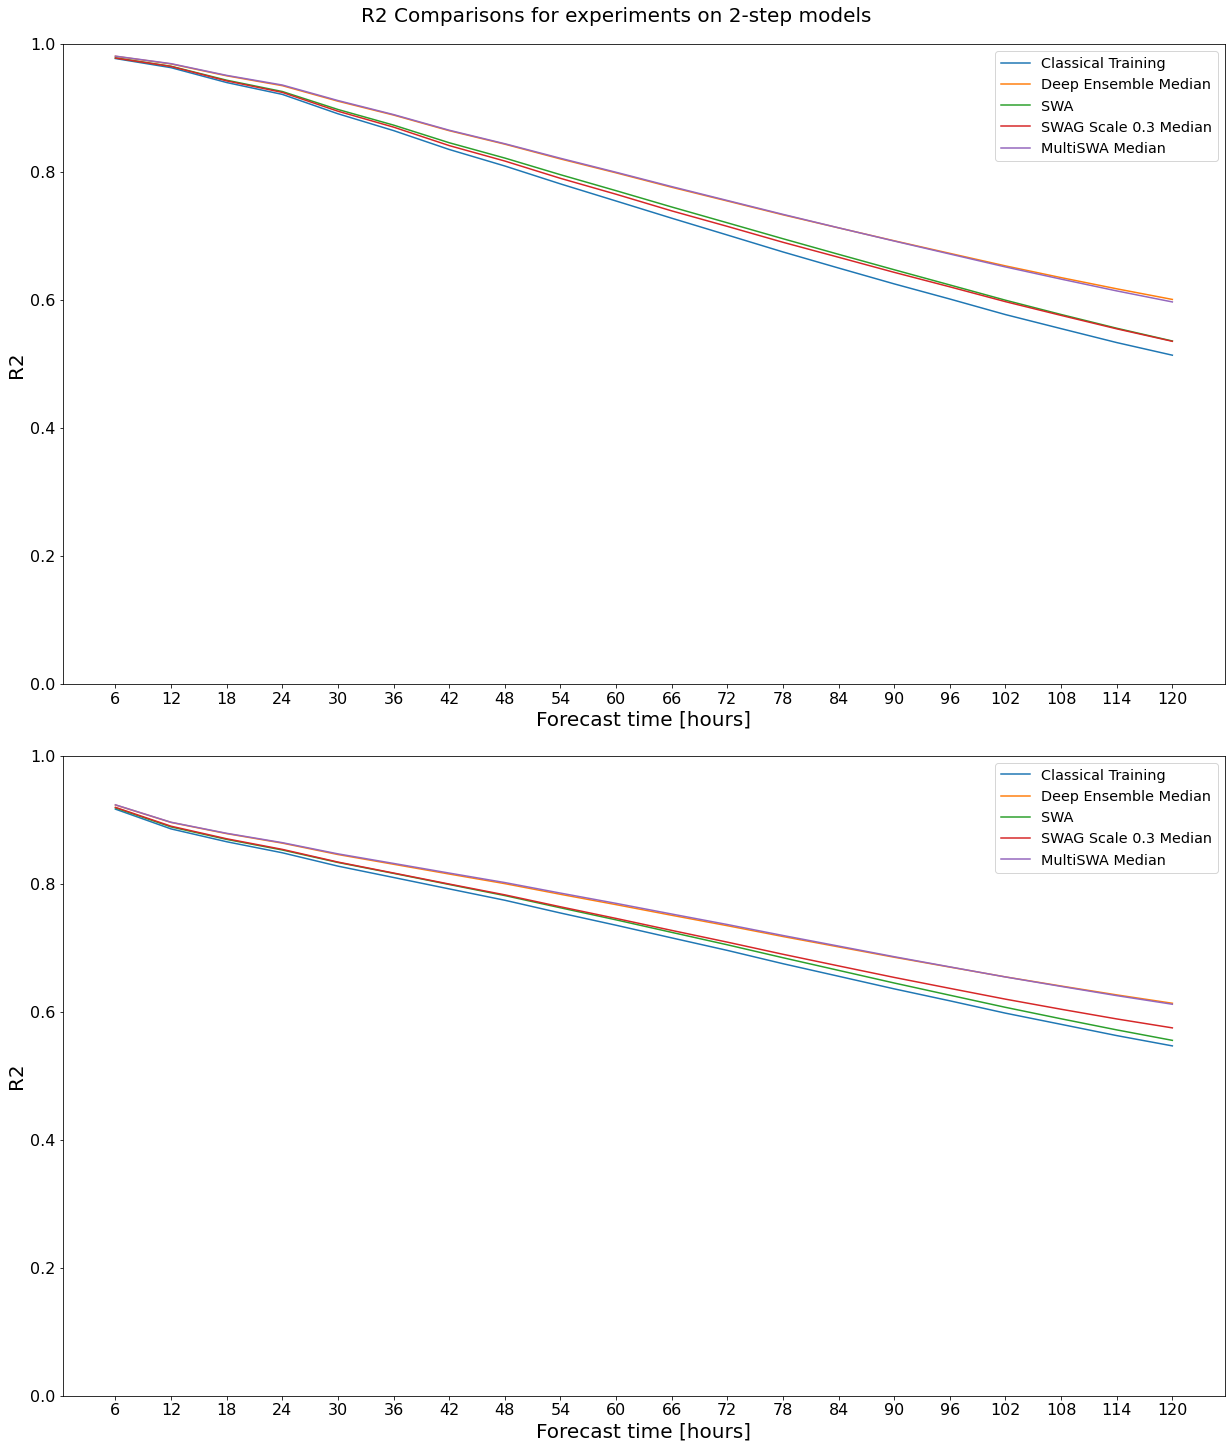

In [28]:
lead_time = 6
max_lead_time = 120
r2_ylim = [0, 1]

labels = [
    'Classical Training',
    'Deep Ensemble Median',
    'SWA',
    'SWAG Scale 0.3 Median',
    'MultiSWA Median'
]

lead_times = corrs[-1].lead_time.values

n_ticks = len(lead_times)

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(17, 20), constrained_layout=True)

for i, corr in enumerate(corrs):
    ax1.plot(lead_times, corr.z.values, label=labels[i])
    ax2.plot(lead_times, corr.t.values, label=labels[i])

ax1.set_ylim(r2_ylim)
ax2.set_ylim(r2_ylim)

ax1.tick_params(axis='y', labelsize=16)
ax2.tick_params(axis='y', labelsize=16)
ax1.set_xlabel('Forecast time [hours]', fontsize=20)
ax1.set_xticks(lead_times)
ax1.tick_params(axis='x', labelsize=16)

ax2.set_xlabel('Forecast time [hours]', fontsize=20)
ax2.set_xticks(lead_times)
ax2.tick_params(axis='x', labelsize=16)

ax1.set_ylabel('R2', fontsize=20)
ax2.set_ylabel('R2', fontsize=20)

f.suptitle('R2 Comparisons for experiments on 2-step models', fontsize=20)
ax1.legend(fontsize='x-large')
ax2.legend(fontsize='x-large')
plt.show()